# Analyse de Clustering avec GMM sur OpenFoodFacts
### Table des matières
1. [Chargement et préparation des données](#1),
2. [Prétraitement et nettoyage](#2),
3. [Sélection des features pour le clustering](#3),
4. [Préparation pour GMM](#4),
5. [Modélisation GMM](#5),
6. [Analyse des clusters](#6),
7. [Visualisation des résultats](#7)

## Chargement et préparation des données


In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

from scripts.features.processing import (
    analyze_correlations,
    process_numeric_columns,
    process_categorical_columns,
    detect_ordinal_nature,
    optimize_categorical_memory,
    handle_rare_categories,
    analyze_category_distributions,
    memory_usage_report,
    enhance_ordinal_detection,
    infer_ordinal_order
)
from scripts.features.selection import (
    analyze_and_select_features,
    analyze_feature_importance,
    select_relevant_features
)
from scripts.features.sampling import select_representative_sample, plot_sampling_results
from scripts.data.analysis import analyze_data_quality

# Chargement des données avec limitation à 300000 lignes
from scripts.data_handling.loader import load_data
df = pd.read_csv('../data/en.openfoodfacts.org.products.csv', 
                 sep='\t',
                 encoding='utf-8',
                 low_memory=False,
                 on_bad_lines='skip',
                 nrows=300000)

1. Analyse de la qualité des données initiales :
⚠️ 196 colonnes sur 206 ont des valeurs manquantes.
allergens_en               100.000000
additives                  100.000000
cities                     100.000000
unsaturated-fat_100g       100.000000
casein_100g                100.000000
                              ...    
cholesterol_100g            58.607667
nutriscore_score            53.245667
nutrition-score-fr_100g     53.245667
nutrient_levels_tags        50.911333
nova_group                  50.390000
Length: 157, dtype: float64

Nombre de lignes dupliquées : 0

Distribution des valeurs manquantes :


allergens_en             100.000000
additives                100.000000
cities                   100.000000
unsaturated-fat_100g     100.000000
casein_100g              100.000000
                            ...    
pnns_groups_1              0.316667
pnns_groups_2              0.316667
completeness               0.004333
last_updated_t             0.000333
last_updated_datetime      0.000333
Length: 196, dtype: float64


2. Détection et prétraitement automatique des variables :
Colonnes numériques : 16
Colonnes ordinales : 1
Colonnes nominales : 1
Colonnes supprimées : 188
Colonnes optimisées : 2

3. Résumé des variables détectées :
Variables numériques : 16
Variables ordinales : 1
Variables nominales : 1

4. Optimisations des types de données :
- created_t: int64 → int32
- last_modified_t: int64 → int32

5. Colonnes filtrées :
- url (raison: too_many_categories)
- creator (raison: too_many_categories)
- created_datetime (raison: too_many_categories)
- last_modified_datetime (raison: too_many_categories)
- last_modified_by (raison: too_many_categories)
- last_updated_datetime (raison: too_many_categories)
- product_name (raison: too_many_categories)
- abbreviated_product_name (raison: too_many_missing)
- generic_name (raison: too_many_missing)
- quantity (raison: too_many_missing)
- packaging (raison: too_many_missing)
- packaging_tags (raison: too_many_missing)
- packaging_en (raison: too_many_missin

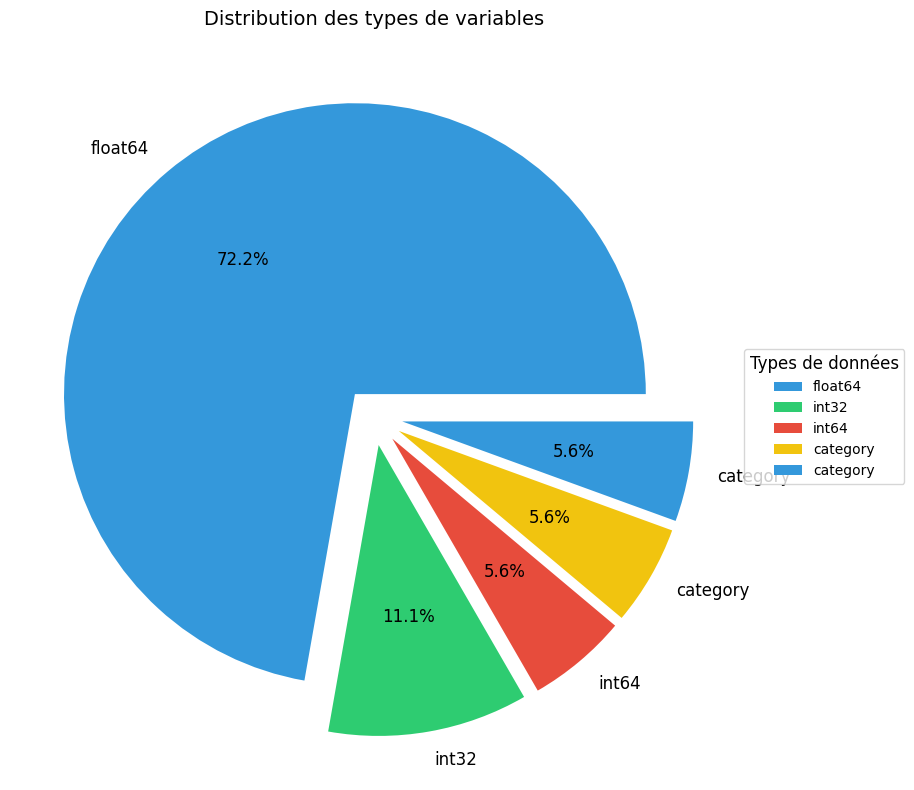

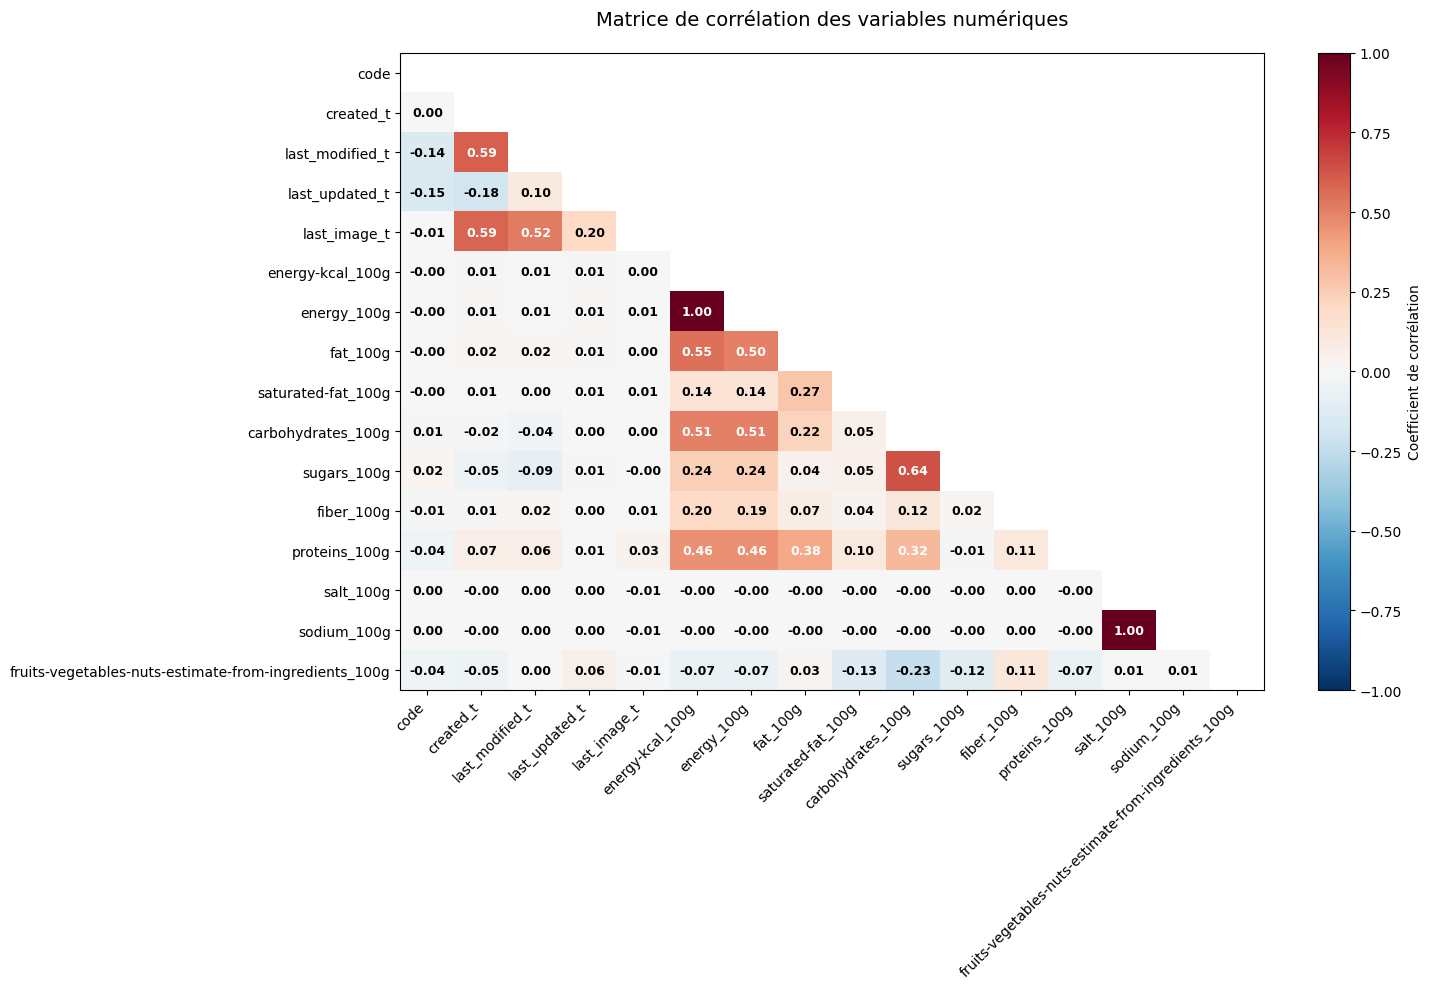

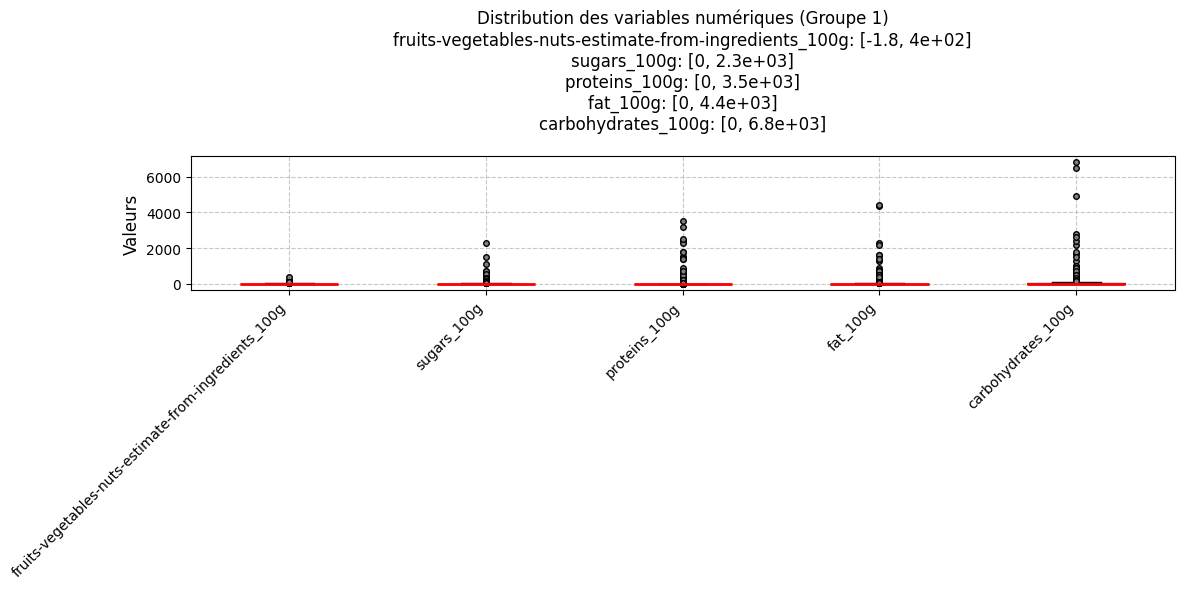


Statistiques détaillées pour le groupe 1

fruits-vegetables-nuts-estimate-from-ingredients_100g:
  Moyenne: 19
  Écart-type: 31
  Min: -1.8
  Max: 4e+02
  Nombre de valeurs non-nulles: 157485

sugars_100g:
  Moyenne: 15
  Écart-type: 22
  Min: 0
  Max: 2.3e+03
  Nombre de valeurs non-nulles: 246413

proteins_100g:
  Moyenne: 7.7
  Écart-type: 18
  Min: 0
  Max: 3.5e+03
  Nombre de valeurs non-nulles: 255808

fat_100g:
  Moyenne: 12
  Écart-type: 23
  Min: 0
  Max: 4.4e+03
  Nombre de valeurs non-nulles: 255403

carbohydrates_100g:
  Moyenne: 33
  Écart-type: 38
  Min: 0
  Max: 6.8e+03
  Nombre de valeurs non-nulles: 256433


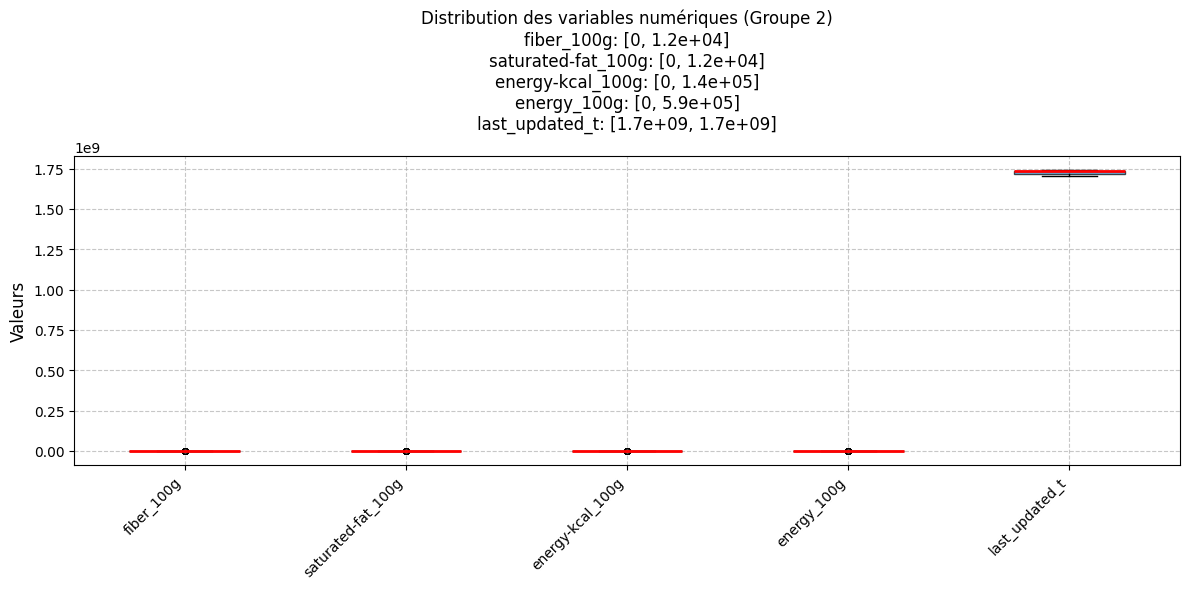


Statistiques détaillées pour le groupe 2

fiber_100g:
  Moyenne: 2.9
  Écart-type: 28
  Min: 0
  Max: 1.2e+04
  Nombre de valeurs non-nulles: 189807

saturated-fat_100g:
  Moyenne: 4.5
  Écart-type: 27
  Min: 0
  Max: 1.2e+04
  Nombre de valeurs non-nulles: 234514

energy-kcal_100g:
  Moyenne: 2.7e+02
  Écart-type: 4.1e+02
  Min: 0
  Max: 1.4e+05
  Nombre de valeurs non-nulles: 256829

energy_100g:
  Moyenne: 1.1e+03
  Écart-type: 1.7e+03
  Min: 0
  Max: 5.9e+05
  Nombre de valeurs non-nulles: 257299

last_updated_t:
  Moyenne: 1.7e+09
  Écart-type: 1.2e+07
  Min: 1.7e+09
  Max: 1.7e+09
  Nombre de valeurs non-nulles: 299999


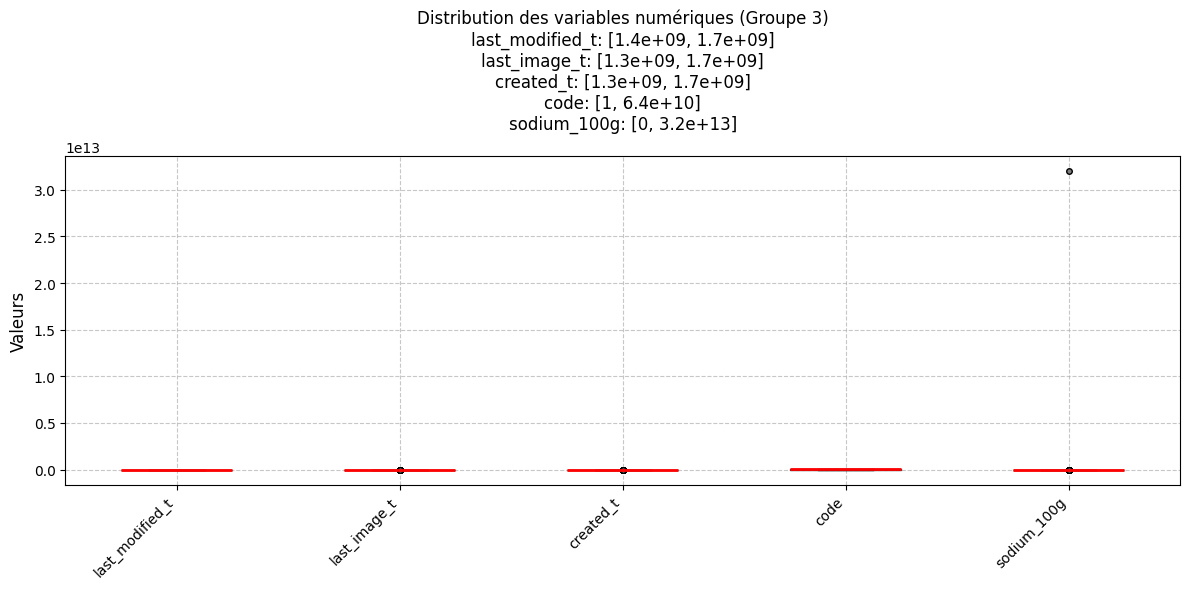


Statistiques détaillées pour le groupe 3

last_modified_t:
  Moyenne: 1.7e+09
  Écart-type: 6e+07
  Min: 1.4e+09
  Max: 1.7e+09
  Nombre de valeurs non-nulles: 300000

last_image_t:
  Moyenne: 1.7e+09
  Écart-type: 4.7e+07
  Min: 1.3e+09
  Max: 1.7e+09
  Nombre de valeurs non-nulles: 165086

created_t:
  Moyenne: 1.6e+09
  Écart-type: 7.8e+07
  Min: 1.3e+09
  Max: 1.7e+09
  Nombre de valeurs non-nulles: 300000

code:
  Moyenne: 3.2e+10
  Écart-type: 1.8e+10
  Min: 1
  Max: 6.4e+10
  Nombre de valeurs non-nulles: 300000

sodium_100g:
  Moyenne: 1.4e+08
  Écart-type: 6.6e+10
  Min: 0
  Max: 3.2e+13
  Nombre de valeurs non-nulles: 232975


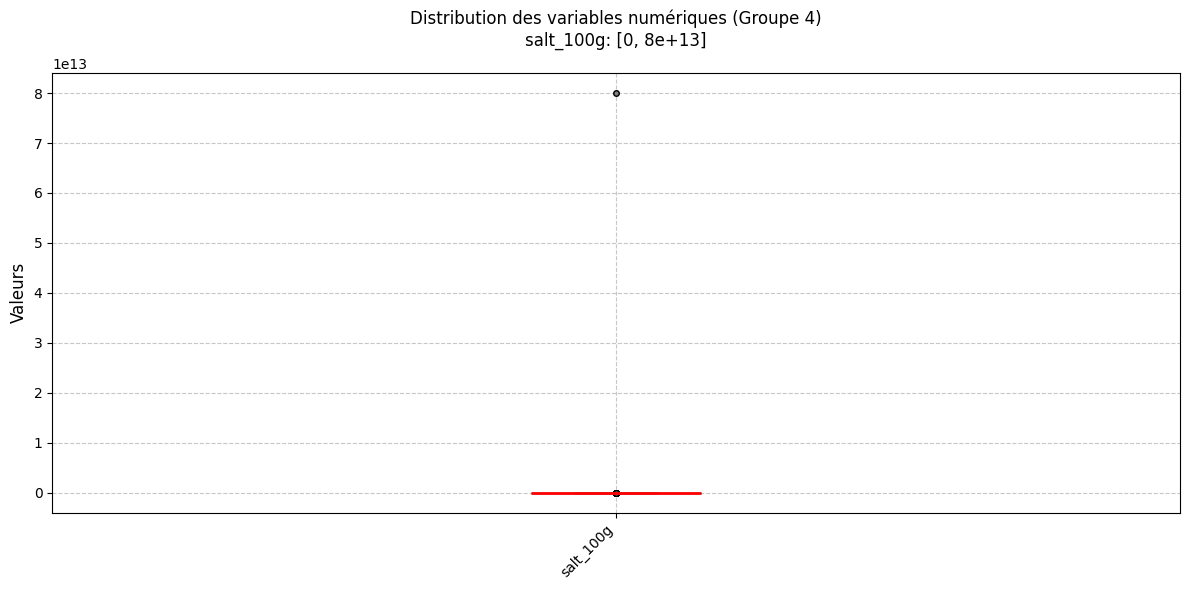


Statistiques détaillées pour le groupe 4

salt_100g:
  Moyenne: 3.4e+08
  Écart-type: 1.7e+11
  Min: 0
  Max: 8e+13
  Nombre de valeurs non-nulles: 232975

Analyse des variables catégorielles :


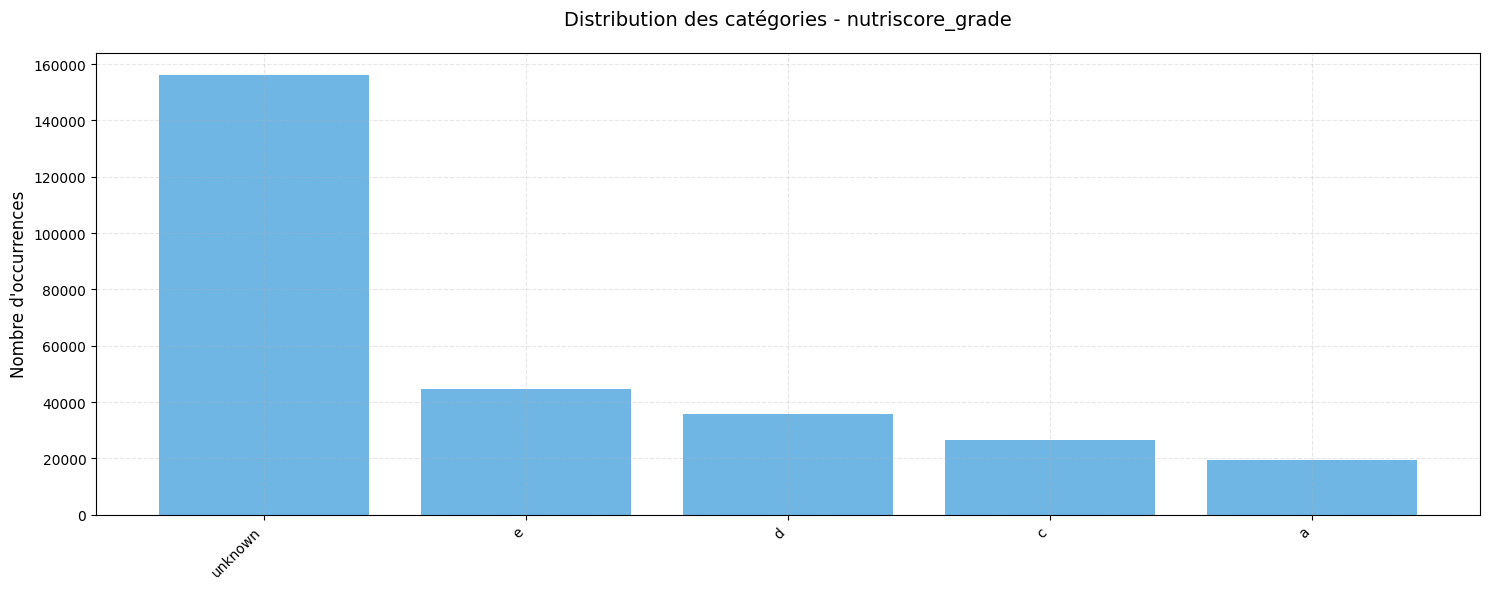

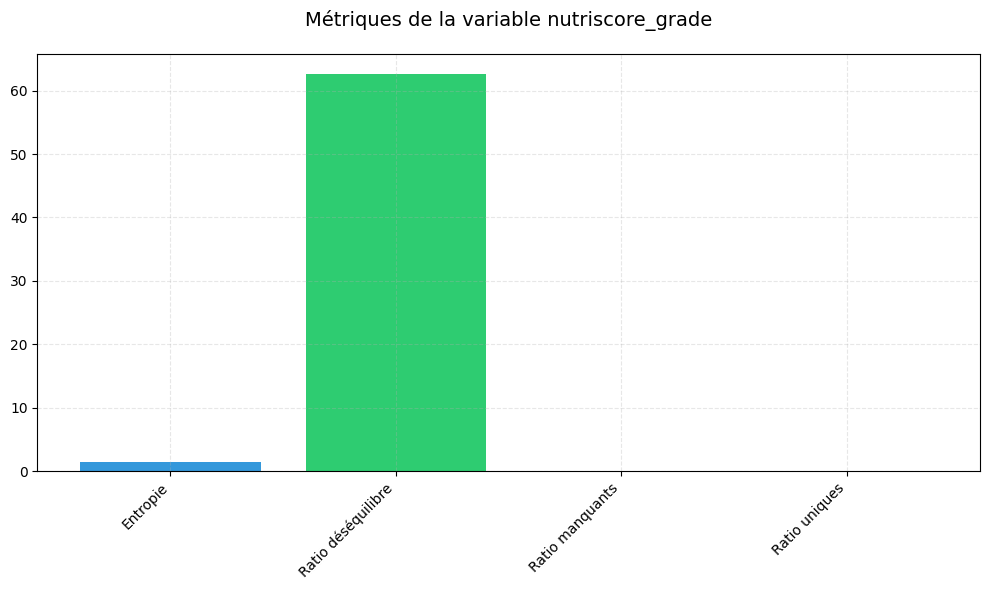

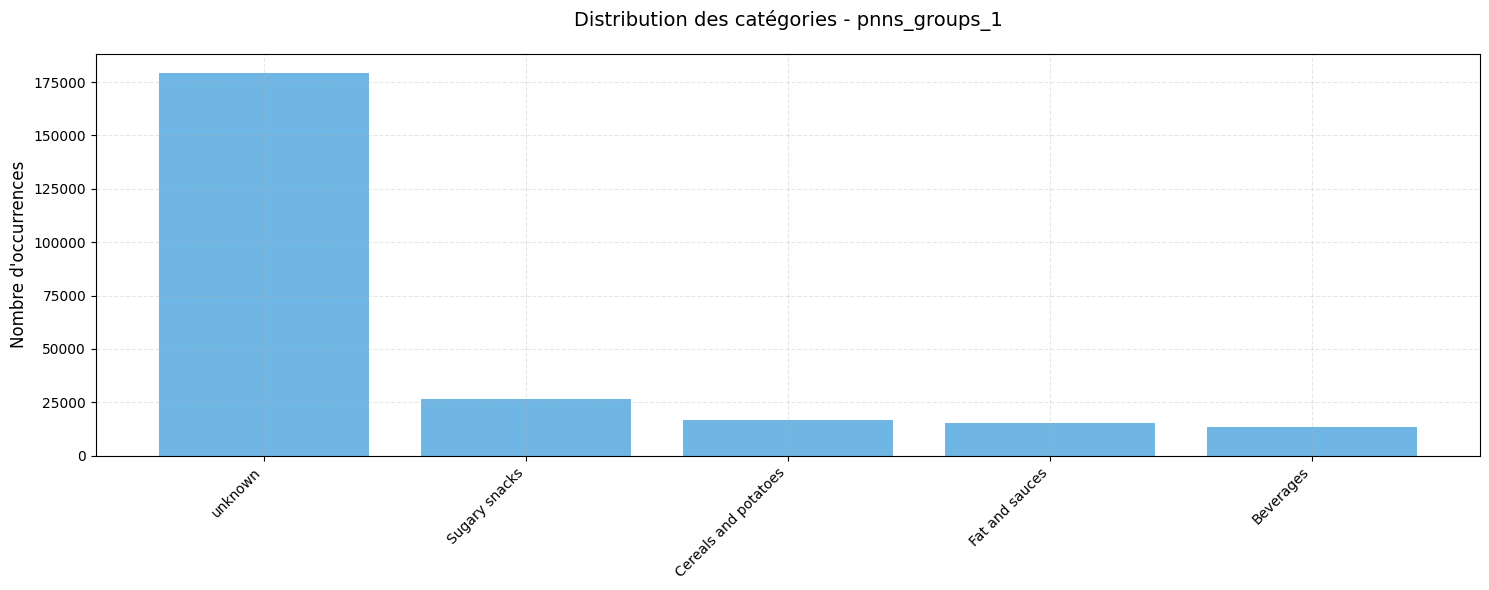

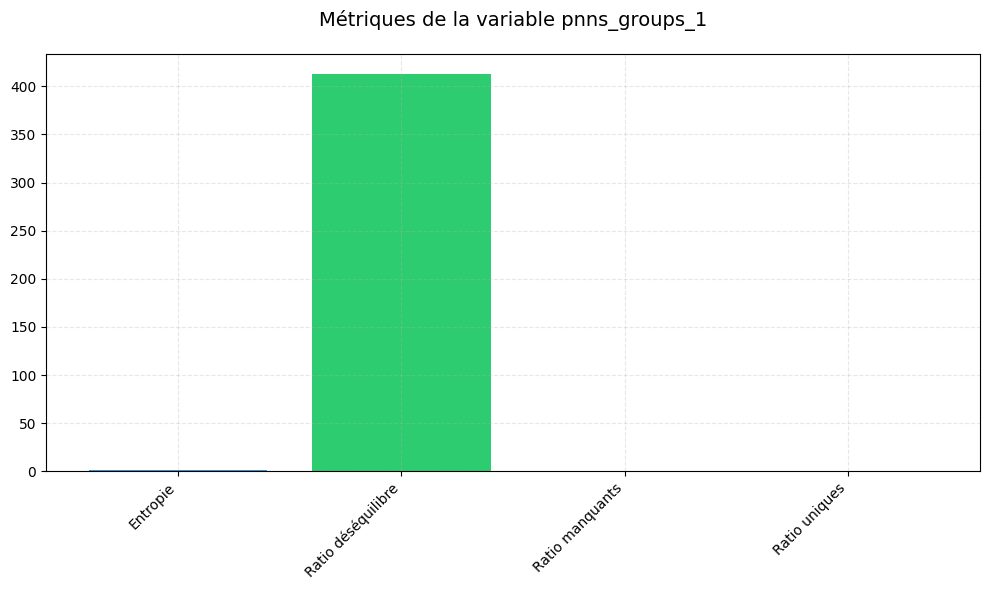


Utilisation de la mémoire :


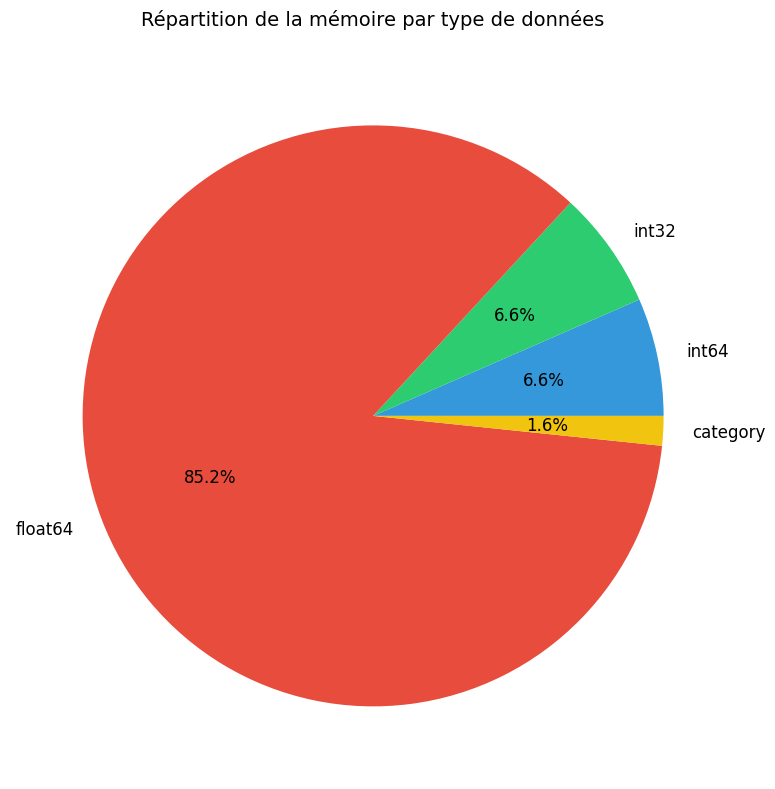

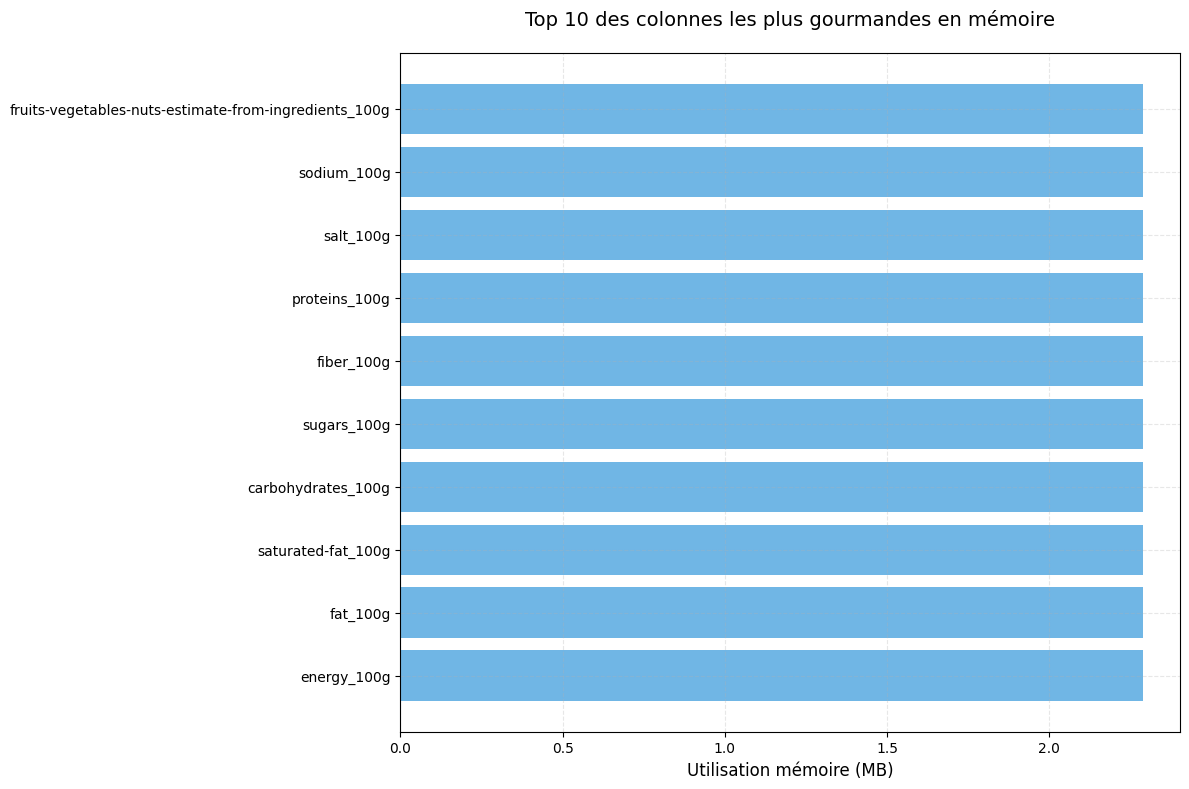

In [2]:
# Paramètres de prétraitement
MAX_CATEGORIES = 30  # Nombre maximum de catégories pour les variables catégorielles
MIN_UNIQUE_RATIO = 0.01  # Ratio minimum de valeurs uniques pour les variables numériques
MISSING_THRESHOLD = 0.5  # Seuil maximum de valeurs manquantes acceptables

# Analyse initiale de la qualité des données
print("1. Analyse de la qualité des données initiales :")
quality_report = analyze_data_quality(df)
print(f"\nNombre de lignes dupliquées : {quality_report['duplicates']}")
print("\nDistribution des valeurs manquantes :")
display(quality_report['missing_values'])

# Prétraitement et sélection automatique des features
print("\n2. Détection et prétraitement automatique des variables :")
df_processed, feature_info = analyze_and_select_features(
    df,
    max_categories=MAX_CATEGORIES,
    min_unique_ratio=MIN_UNIQUE_RATIO,
    missing_threshold=MISSING_THRESHOLD
)
from scripts.visualization.data_quality_viz import (
    plot_data_quality_dashboard,
    plot_categorical_analysis,
    plot_memory_usage
)

# Affichage des résultats du prétraitement
print("\n3. Résumé des variables détectées :")
print(f"Variables numériques : {len(feature_info['feature_types']['numeric'])}")
print(f"Variables ordinales : {len(feature_info['feature_types']['ordinal'])}")
print(f"Variables nominales : {len(feature_info['feature_types']['nominal'])}")

# Affichage des optimisations de types de données
if feature_info['downcasted_columns']:
    print("\n4. Optimisations des types de données :")
    for col, old_type, new_type in feature_info['downcasted_columns']:
        print(f"- {col}: {old_type} → {new_type}")

# Affichage des colonnes filtrées
if feature_info['dropped_columns']:
    print("\n5. Colonnes filtrées :")
    for col, reason in feature_info['dropped_columns']:
        print(f"- {col} (raison: {reason})")

# Analyse des corrélations entre variables numériques
print("\n6. Analyse des corrélations entre variables numériques :")
correlations = analyze_correlations(df_processed, threshold=0.7, plot=True)
if correlations['strong_correlations']:
    print("\nPaires de variables fortement corrélées :")
    for corr in correlations['strong_correlations']:
        print(f"- {corr['var1']} - {corr['var2']}: {corr['correlation']:.2f}")

# Sauvegarde du DataFrame prétraité
df = df_processed.copy()
print(f"\nDimensions finales du DataFrame : {df.shape}")

# Nouvelles analyses avec les fonctionnalités ajoutées
print("\n7. Analyse approfondie des variables catégorielles :")

# Optimisation de la mémoire
print("\nOptimisation de la mémoire pour les variables catégorielles :")
df_optimized, memory_info = optimize_categorical_memory(df)
for col, savings in memory_info['memory_savings'].items():
    print(f"- {col}: {savings['savings_percent']:.2f}% d'économie de mémoire")

# Analyse des distributions des catégories
print("\nAnalyse des distributions des catégories :")
category_distributions = analyze_category_distributions(df)
for col, dist_info in category_distributions.items():
    print(f"\nColonne {col}:")
    print(f"- Nombre de catégories: {dist_info['n_categories']}")
    print(f"- Ratio de déséquilibre: {dist_info['imbalance_ratio']:.2f}")
    print(f"- Entropie: {dist_info['entropy']:.2f}")
    print("- Top 5 catégories les plus fréquentes:")
    for cat, count in dist_info['most_common'].items():
        print(f"  * {cat}: {count}")

# Gestion des catégories rares
print("\nGestion des catégories rares (seuil de 1%) :")
df_processed_rare, rare_info = handle_rare_categories(df, threshold=0.01)
for col, info in rare_info['modified_columns'].items():
    print(f"\nColonne {col}:")
    print(f"- Catégories initiales: {info['initial_categories']}")
    print(f"- Catégories finales: {info['final_categories']}")
    if col in rare_info['grouped_categories']:
        print(f"- Nombre de catégories regroupées: {rare_info['grouped_categories'][col]['n_grouped']}")

# Rapport d'utilisation de la mémoire
print("\n8. Rapport d'utilisation de la mémoire :")
memory_report = memory_usage_report(df)
print(f"Mémoire totale: {memory_report['total_memory_mb']:.2f} MB")
print("\nSuggestions d'optimisation:")
for suggestion in memory_report['optimization_suggestions']:
    print(f"- {suggestion}")

# Mise à jour du DataFrame avec les optimisations
df = df_optimized.copy()
print(f"\nDimensions finales après optimisation : {df.shape}")

# Visualisation du dashboard de qualité des données
print("Dashboard de qualité des données :")
plot_data_quality_dashboard(df, quality_report)

# Visualisation de l'analyse des variables catégorielles
print("\nAnalyse des variables catégorielles :")
plot_categorical_analysis(df, category_distributions)

# Visualisation de l'utilisation de la mémoire
print("\nUtilisation de la mémoire :")
plot_memory_usage(memory_report)

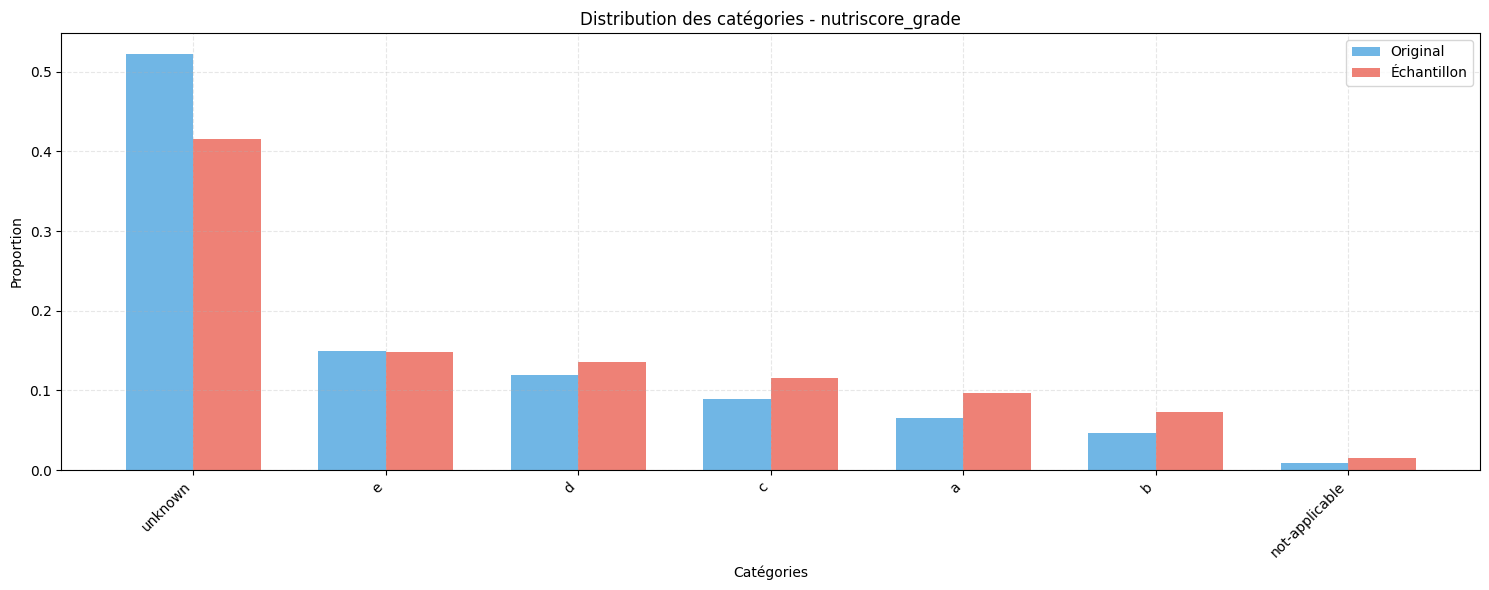

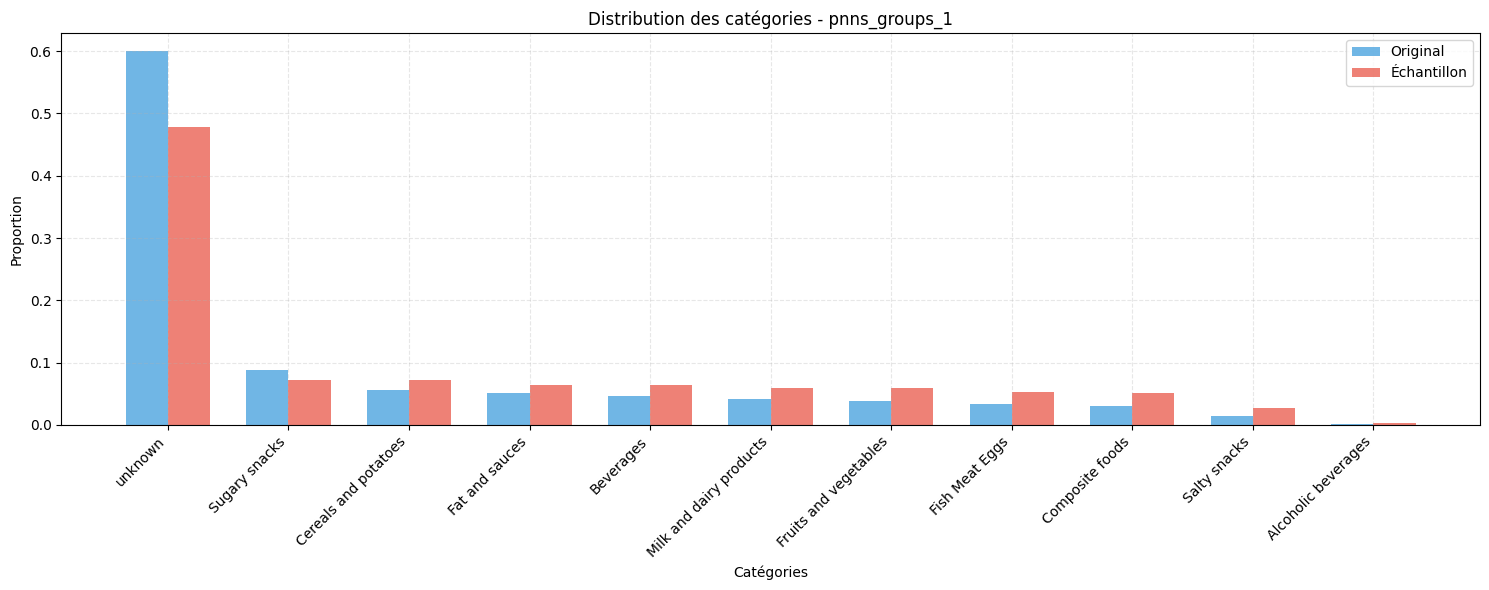

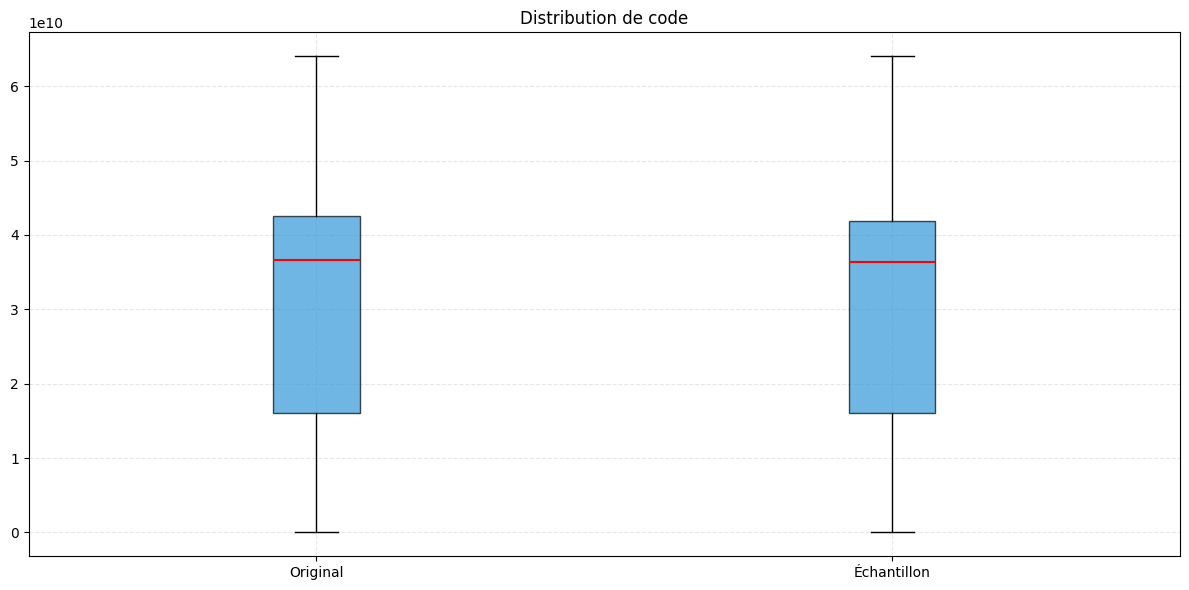


Statistiques pour code:
           Original   Échantillon
count  3.000000e+05  1.653690e+05
mean   3.174487e+10  3.155235e+10
std    1.813543e+10  1.781630e+10
min    1.000000e+00  2.000000e+00
25%    1.600015e+10  1.600015e+10
50%    3.663200e+10  3.642660e+10
75%    4.256302e+10  4.190009e+10
max    6.404260e+10  6.404260e+10


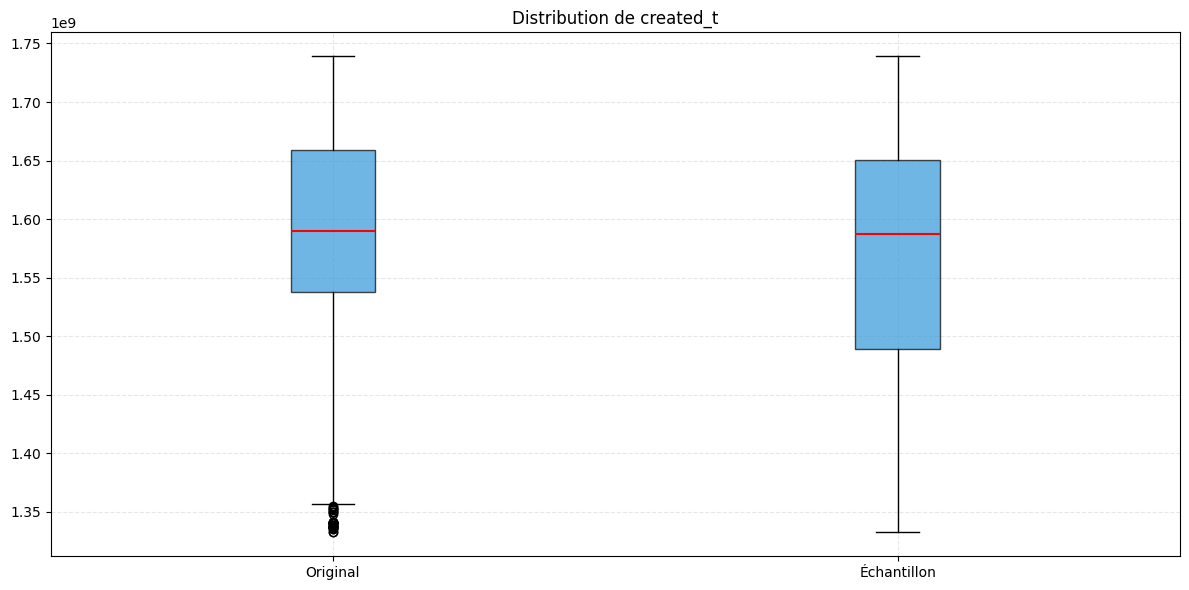


Statistiques pour created_t:
           Original   Échantillon
count  3.000000e+05  1.653690e+05
mean   1.600827e+09  1.590180e+09
std    7.821758e+07  7.748486e+07
min    1.332445e+09  1.332445e+09
25%    1.537404e+09  1.489140e+09
50%    1.589894e+09  1.587666e+09
75%    1.659041e+09  1.650746e+09
max    1.739165e+09  1.739165e+09


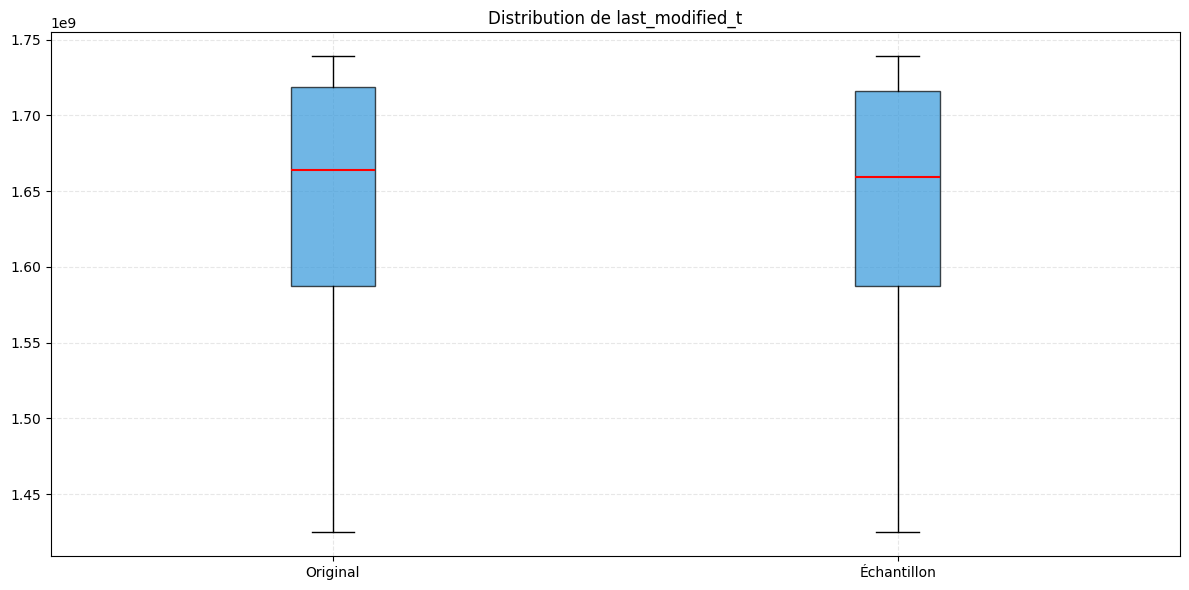


Statistiques pour last_modified_t:
           Original   Échantillon
count  3.000000e+05  1.653690e+05
mean   1.655969e+09  1.652276e+09
std    6.026197e+07  6.039922e+07
min    1.424628e+09  1.424628e+09
25%    1.587660e+09  1.587648e+09
50%    1.664225e+09  1.659682e+09
75%    1.718830e+09  1.716145e+09
max    1.739165e+09  1.739165e+09


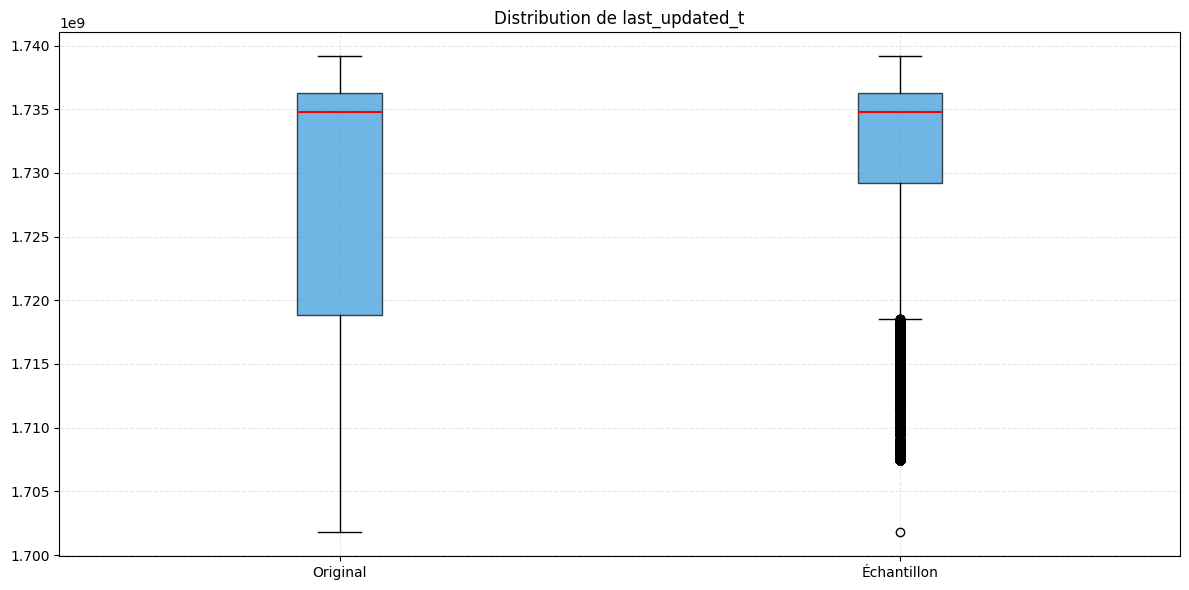


Statistiques pour last_updated_t:
           Original   Échantillon
count  2.999990e+05  1.653690e+05
mean   1.728260e+09  1.729787e+09
std    1.219385e+07  1.125112e+07
min    1.701775e+09  1.701775e+09
25%    1.718830e+09  1.729182e+09
50%    1.734779e+09  1.734783e+09
75%    1.736296e+09  1.736277e+09
max    1.739165e+09  1.739165e+09


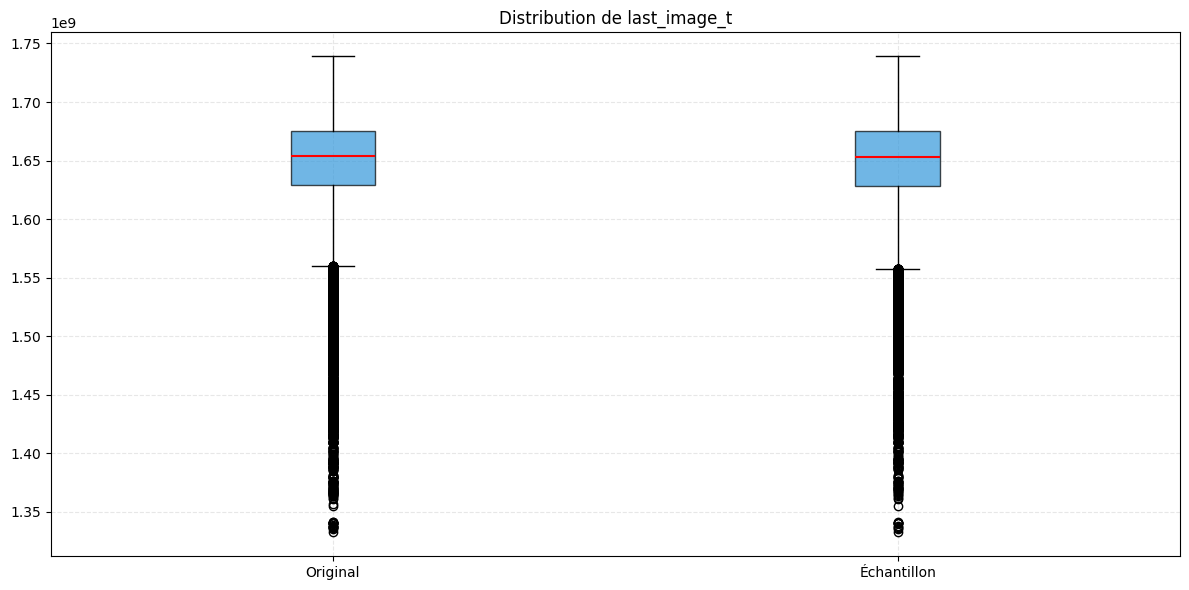


Statistiques pour last_image_t:
           Original   Échantillon
count  1.650860e+05  8.516900e+04
mean   1.651588e+09  1.650261e+09
std    4.732306e+07  4.879795e+07
min    1.332445e+09  1.332445e+09
25%    1.629153e+09  1.628277e+09
50%    1.654047e+09  1.653263e+09
75%    1.675472e+09  1.675452e+09
max    1.739164e+09  1.739161e+09


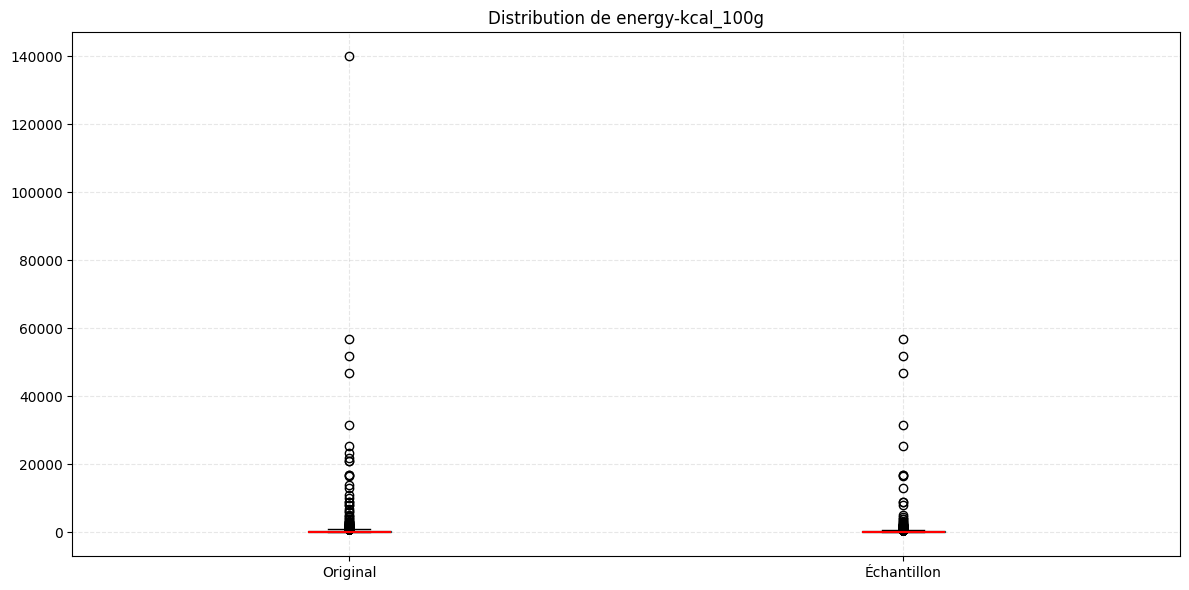


Statistiques pour energy-kcal_100g:
            Original    Échantillon
count  256829.000000  145236.000000
mean      266.595426     252.942690
std       406.209140     335.179363
min         0.000000       0.000000
25%        85.000000      73.233149
50%       258.333300     235.000000
75%       400.000000     386.000000
max    140000.000000   57000.000000


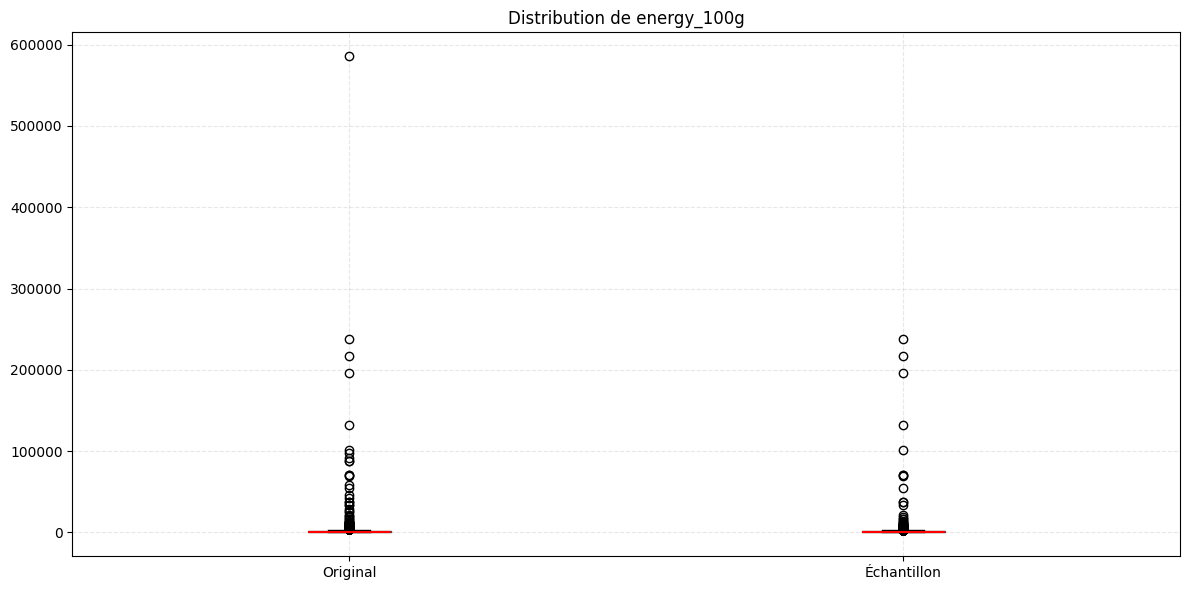


Statistiques pour energy_100g:
            Original    Échantillon
count  257299.000000  145553.000000
mean     1115.001308    1057.902482
std      1697.461932    1399.300618
min         0.000000       0.000000
25%       356.000000     305.000000
50%      1080.000000     983.000000
75%      1670.000000    1615.000000
max    585760.000000  238488.000000


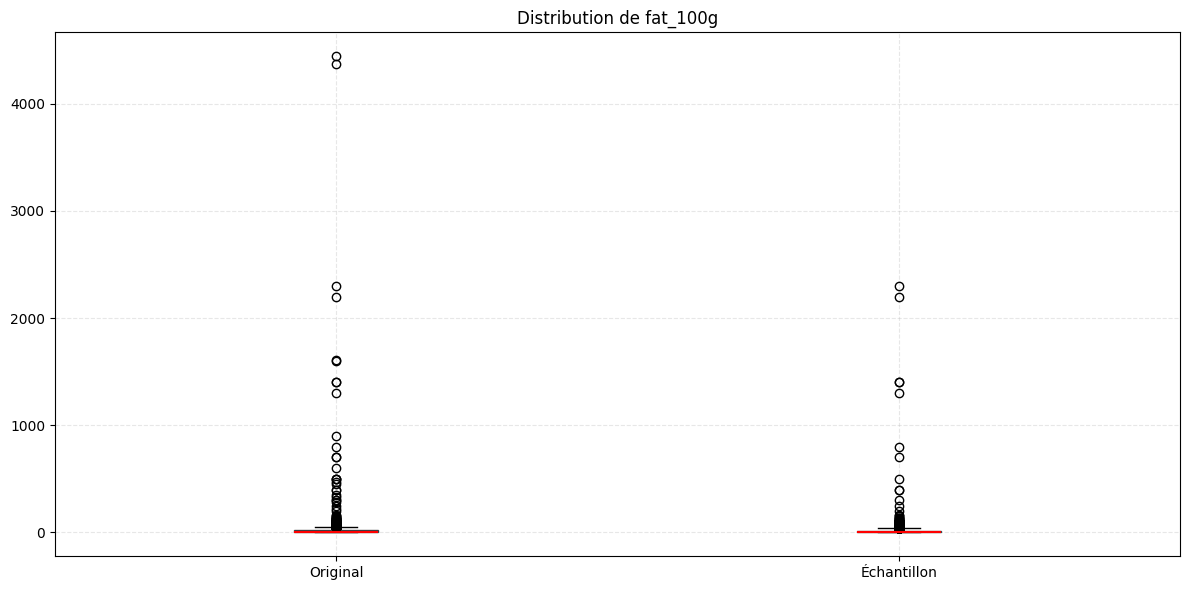


Statistiques pour fat_100g:
            Original    Échantillon
count  255403.000000  144738.000000
mean       12.223438      11.713304
std        22.981674      20.109450
min         0.000000       0.000000
25%         0.000000       0.000000
50%         5.000000       4.000000
75%        19.050000      17.857143
max      4444.000000    2300.000000


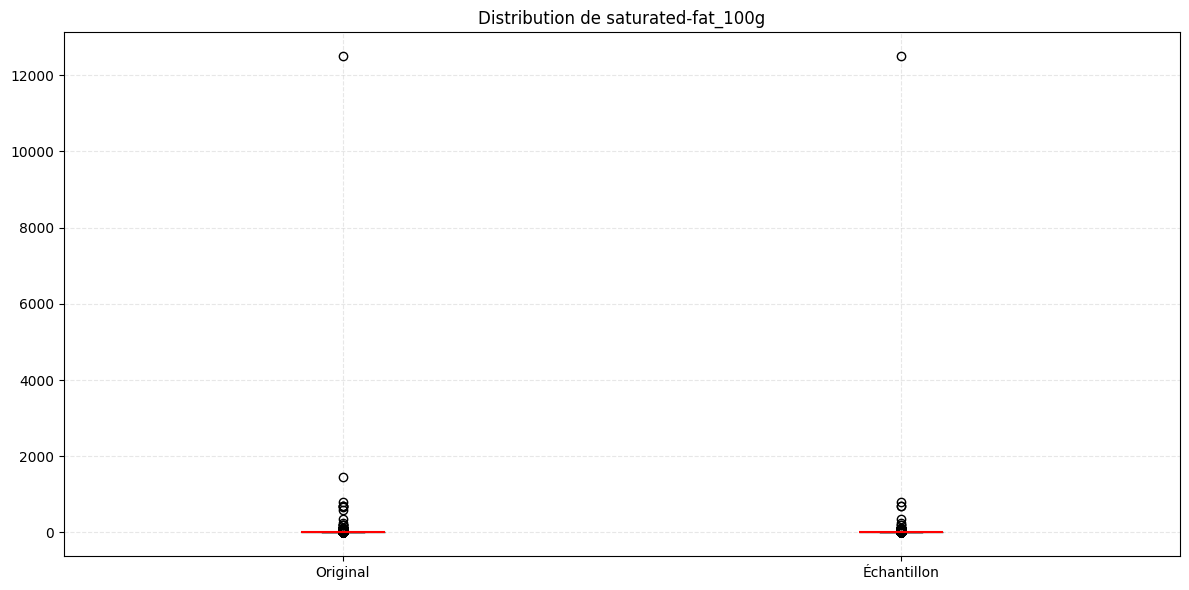


Statistiques pour saturated-fat_100g:
            Original    Échantillon
count  234514.000000  132831.000000
mean        4.525400       4.271364
std        27.186161      35.178148
min         0.000000       0.000000
25%         0.000000       0.000000
50%         1.500000       1.190476
75%         6.609482       5.833333
max     12500.000000   12500.000000


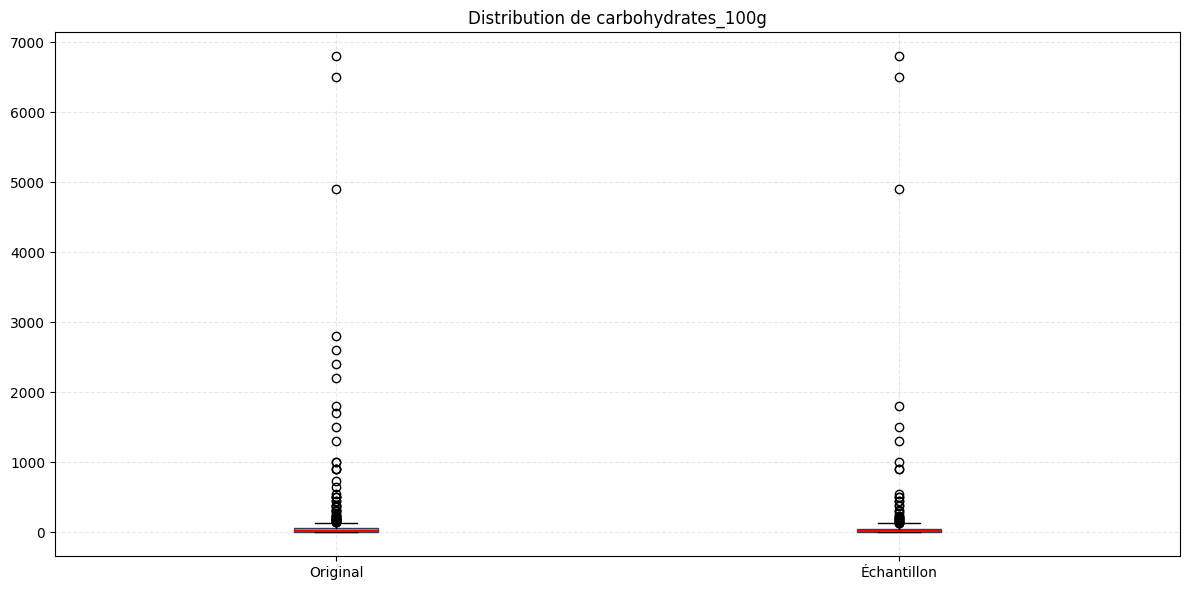


Statistiques pour carbohydrates_100g:
            Original    Échantillon
count  256433.000000  145211.000000
mean       32.694244      30.186233
std        38.005504      40.748013
min         0.000000       0.000000
25%         6.666667       5.710000
50%        21.430000      17.690000
75%        59.375000      55.805000
max      6800.000000    6800.000000


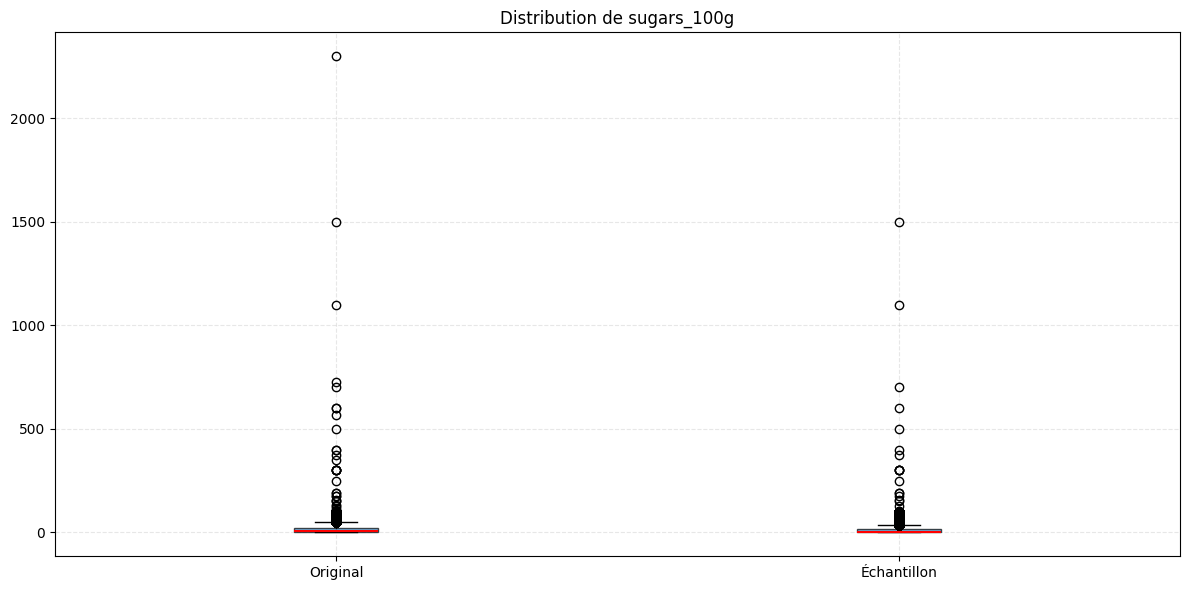


Statistiques pour sugars_100g:
            Original    Échantillon
count  246413.000000  139529.000000
mean       14.907149      12.945379
std        21.623695      19.959346
min         0.000000       0.000000
25%         1.000000       0.830000
50%         5.000000       4.070000
75%        21.428571      15.690000
max      2300.000000    1500.000000


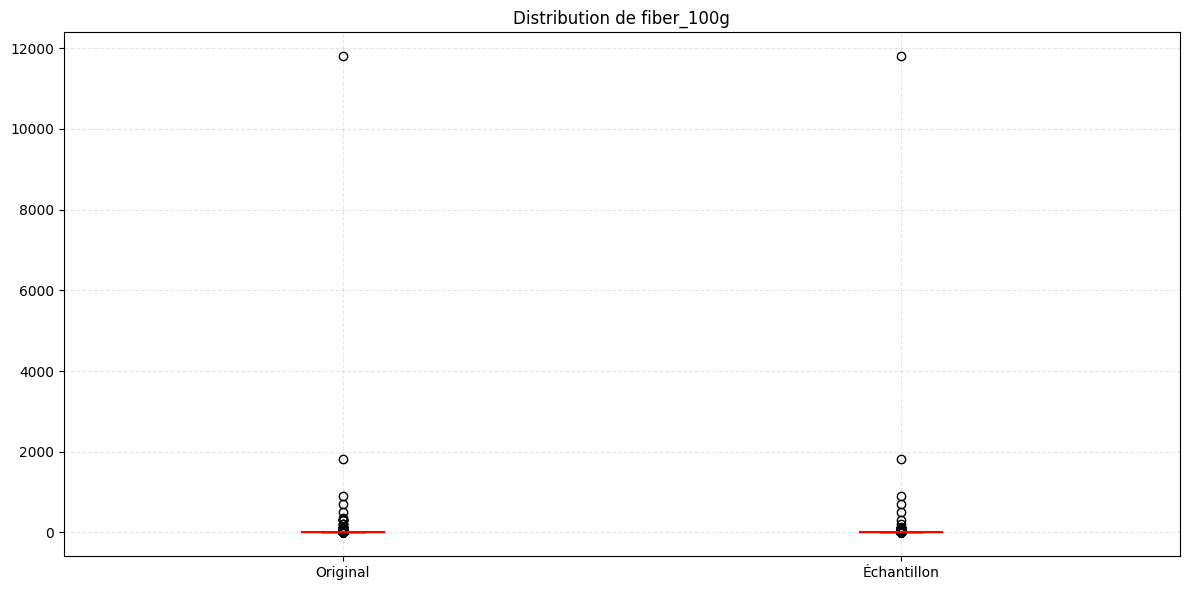


Statistiques pour fiber_100g:
            Original    Échantillon
count  189807.000000  109885.000000
mean        2.895873       2.857721
std        28.044426      36.534615
min         0.000000       0.000000
25%         0.000000       0.000000
50%         1.428600       1.400000
75%         3.571429       3.530000
max     11800.000000   11800.000000


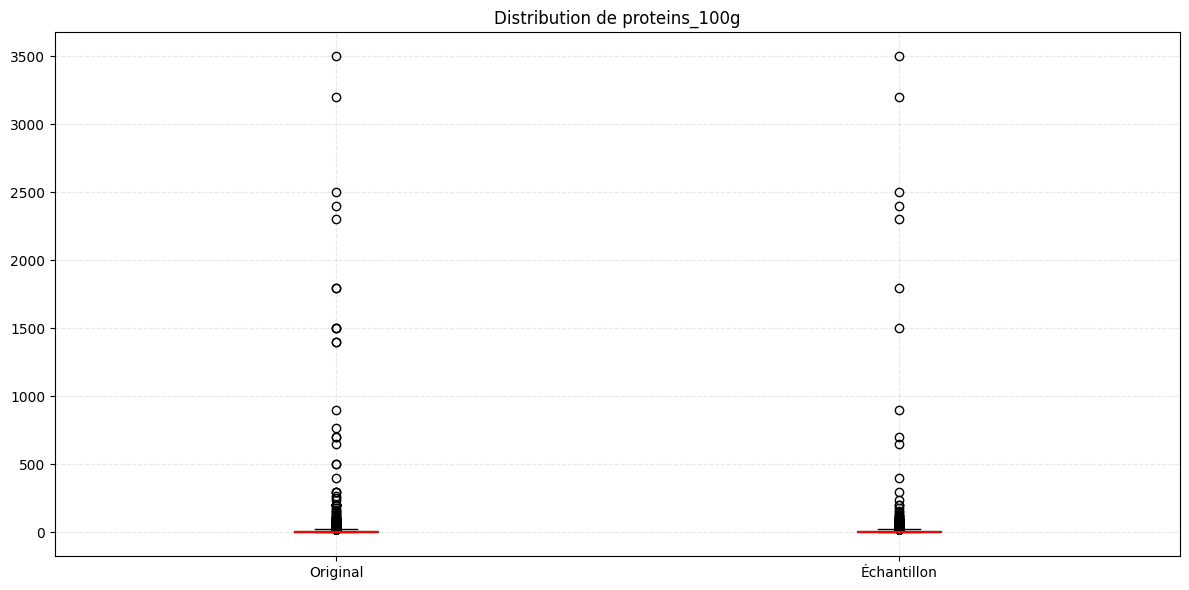


Statistiques pour proteins_100g:
            Original    Échantillon
count  255808.000000  144912.000000
mean        7.662476       7.685958
std        18.281252      20.410329
min         0.000000       0.000000
25%         0.710000       0.729982
50%         4.710000       4.710000
75%        10.000000      10.620000
max      3500.000000    3500.000000


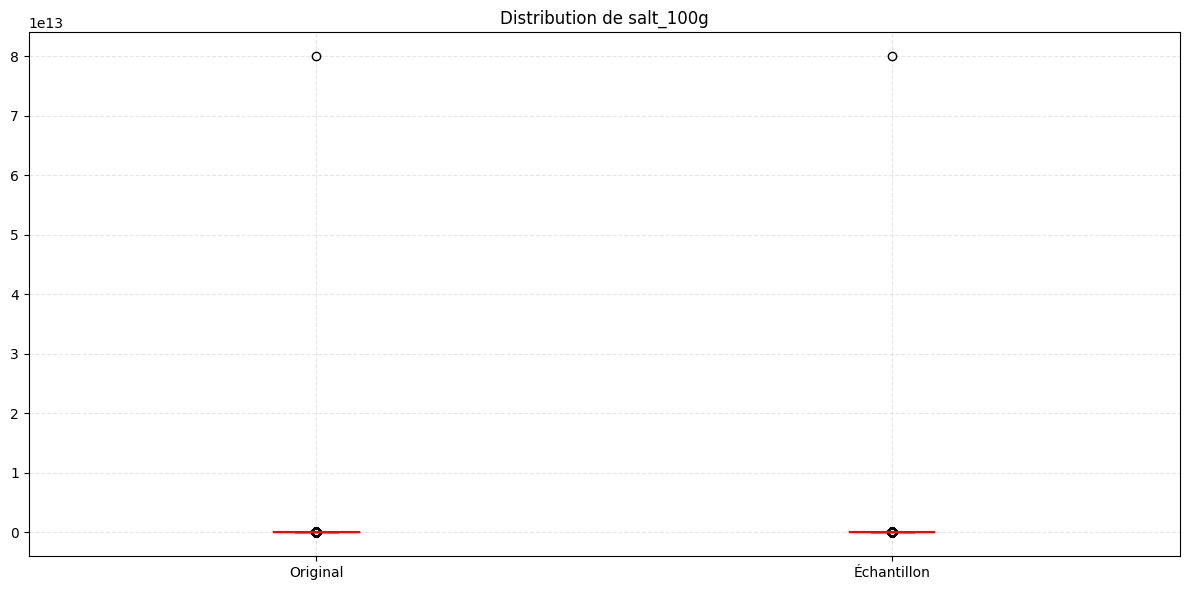


Statistiques pour salt_100g:
           Original   Échantillon
count  2.329750e+05  1.345180e+05
mean   3.433845e+08  5.947160e+08
std    1.657431e+11  2.181222e+11
min    0.000000e+00  0.000000e+00
25%    1.050000e-01  8.820000e-02
50%    6.775000e-01  6.706459e-01
75%    1.477500e+00  1.465000e+00
max    8.000000e+13  8.000000e+13


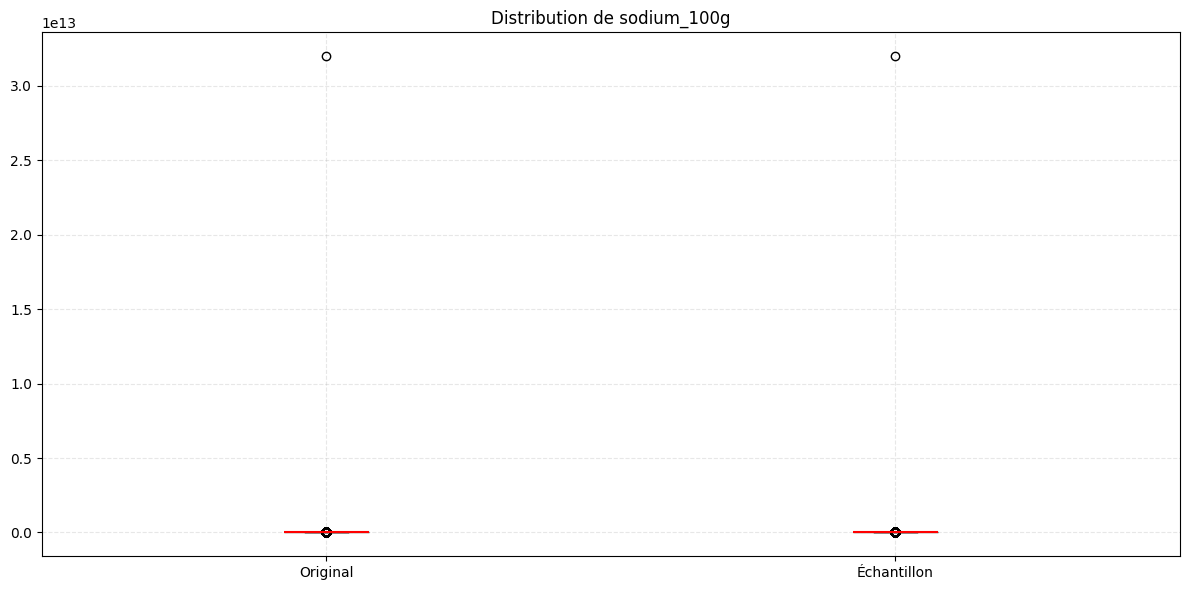


Statistiques pour sodium_100g:
           Original   Échantillon
count  2.329750e+05  1.345180e+05
mean   1.373538e+08  2.378864e+08
std    6.629722e+10  8.724886e+10
min    0.000000e+00  0.000000e+00
25%    4.200000e-02  3.530000e-02
50%    2.710000e-01  2.682240e-01
75%    5.907290e-01  5.860000e-01
max    3.200000e+13  3.200000e+13


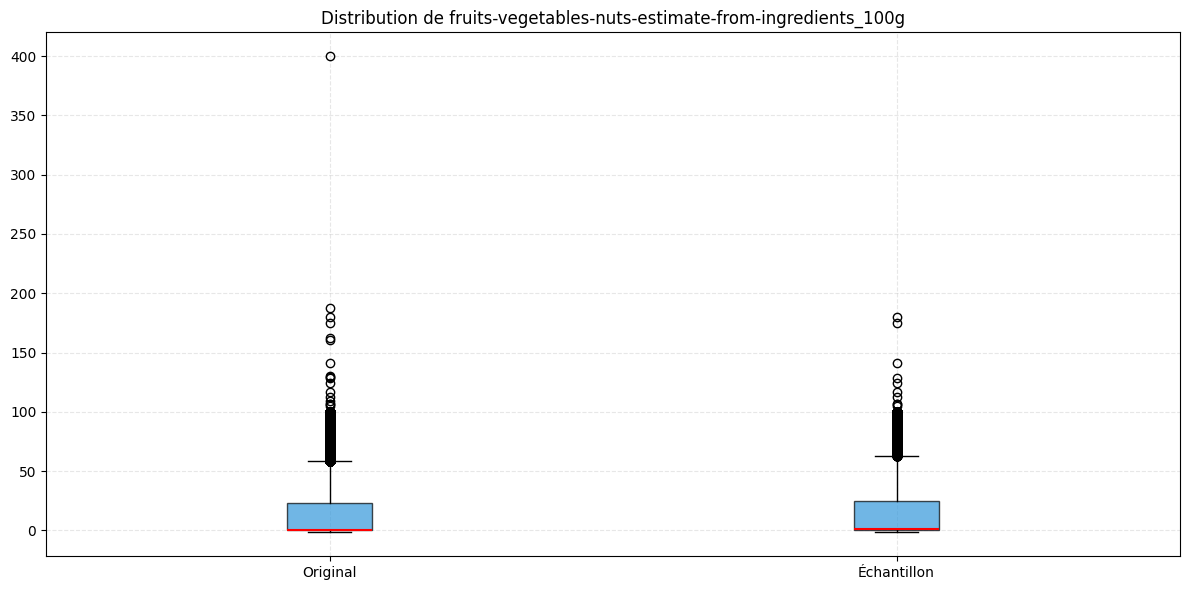


Statistiques pour fruits-vegetables-nuts-estimate-from-ingredients_100g:
            Original   Échantillon
count  157485.000000  99546.000000
mean       19.049537     20.763687
std        31.121305     32.594358
min        -1.779167     -1.357772
25%         0.000000      0.000000
50%         0.710227      0.939835
75%        23.232439     25.172263
max       400.000000    180.375000

Résumé de l'échantillonnage:
Taille originale: 300000
Taille de l'échantillon: 165369
Ratio: 55.1%


In [3]:
# Sélection d'un échantillon représentatif (30% des données par défaut)
sampled_df, sampling_info = select_representative_sample(
    df,
    sample_size=0.3,  # 30% des données
    stratify_columns=['nutriscore_grade', 'pnns_groups_1'],  # Colonnes pour la stratification
    balance_rare_categories=True,  # Suréchantillonnage des catégories rares
    min_category_size=100  # Taille minimale pour chaque catégorie
)
# Visualisation des résultats
plot_sampling_results(df, sampled_df, sampling_info)